In [1]:
!wget https://github.com/kekonline/TensorFlow-Transfer-Learning/raw/master/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix
from helper_functions import make_confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import itertools

IMG_SIZE = (224, 224)

--2024-01-15 19:45:28--  https://github.com/kekonline/TensorFlow-Transfer-Learning/raw/master/helper_functions.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kekonline/TensorFlow-Transfer-Learning/master/helper_functions.py [following]
--2024-01-15 19:45:28--  https://raw.githubusercontent.com/kekonline/TensorFlow-Transfer-Learning/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10127 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2024-01-15 19:45:28 (89.1 MB/s) - ‘helper_fu

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-15 19:45:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  37.4MB/s    in 46s     

2024-01-15 19:46:23 (33.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [4]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [5]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [6]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [8]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 171s 672ms/step - loss: 3.3744 - accuracy: 0.2697 - val_loss: 2.4680 - val_accuracy: 0.4711
Epoch 2/5
237/237 [==============================] - 104s 436ms/step - loss: 2.2027 - accuracy: 0.4953 - val_loss: 2.0155 - val_accuracy: 0.5289
Epoch 3/5
237/237 [==============================] - 100s 419ms/step - loss: 1.8194 - accuracy: 0.5669 - val_loss: 1.8580 - val_accuracy: 0.5432
Epoch 4/5
237/237 [==============================] - 88s 370ms/step - loss: 1.5980 - accuracy: 0.6129 - val_loss: 1.7853 - val_accuracy: 0.5463
Epoch 5/5
237/237 [==============================] - 82s 344ms/step - loss: 1.4276 - accuracy: 0.6532 - val_loss: 1.7280 - val_accuracy: 0.5556


In [9]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 60s 76ms/step - loss: 1.5830 - accuracy: 0.5832


[1.5829861164093018, 0.5832475423812866]

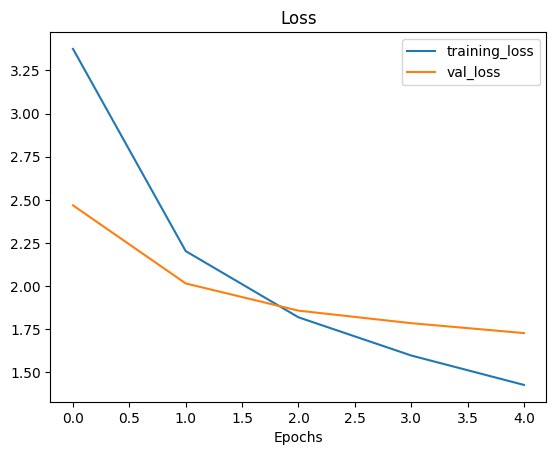

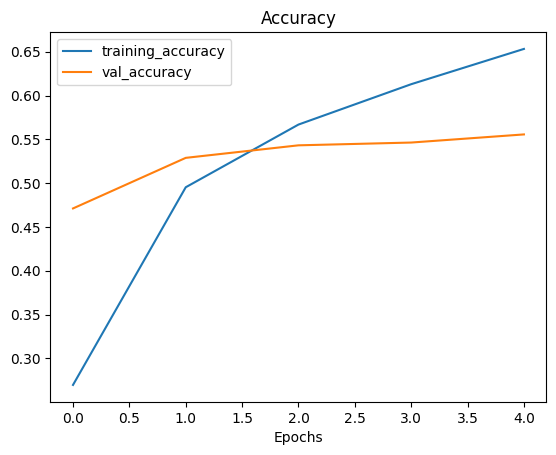

In [10]:
plot_loss_curves(history_all_classes_10_percent)

In [11]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [12]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [13]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [14]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [15]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 85s 310ms/step - loss: 1.2086 - accuracy: 0.6787 - val_loss: 1.6928 - val_accuracy: 0.5546
Epoch 6/10
237/237 [==============================] - 65s 275ms/step - loss: 1.0979 - accuracy: 0.7114 - val_loss: 1.6827 - val_accuracy: 0.5580
Epoch 7/10
237/237 [==============================] - 63s 267ms/step - loss: 1.0153 - accuracy: 0.7281 - val_loss: 1.6663 - val_accuracy: 0.5633
Epoch 8/10
237/237 [==============================] - 57s 241ms/step - loss: 0.9597 - accuracy: 0.7436 - val_loss: 1.6710 - val_accuracy: 0.5665
Epoch 9/10
237/237 [==============================] - 54s 225ms/step - loss: 0.8778 - accuracy: 0.7669 - val_loss: 1.6894 - val_accuracy: 0.5609
Epoch 10/10
237/237 [==============================] - 61s 257ms/step - loss: 0.8189 - accuracy: 0.7835 - val_loss: 1.7100 - val_accuracy: 0.5535


In [16]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 54s 68ms/step - loss: 1.5127 - accuracy: 0.6019


[1.5126709938049316, 0.6018613576889038]

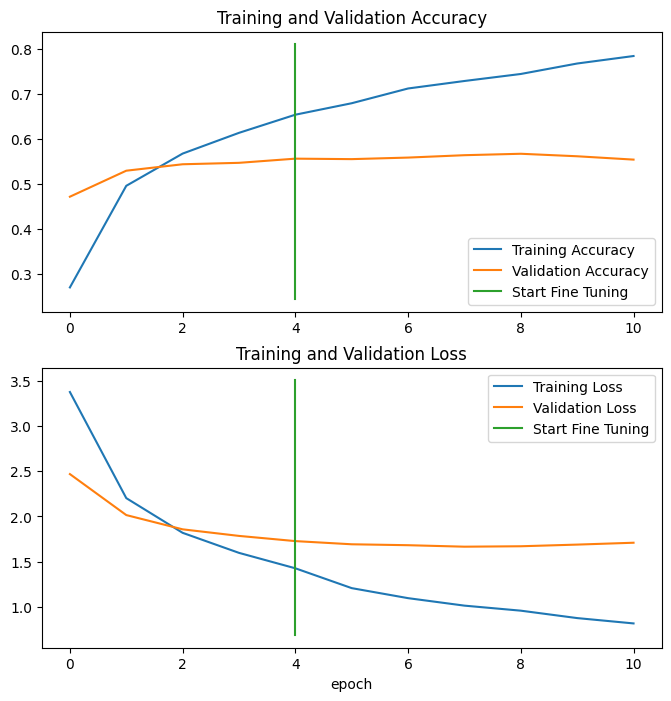

In [17]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [18]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

790/790 [==============================] - 66s 81ms/step


In [19]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 55s 70ms/step - loss: 1.5127 - accuracy: 0.6019


(1.5126709938049316, 0.6018613576889038)

In [20]:
# How many predictions are there?
len(pred_probs)

25250

In [21]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

In [22]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.80042490e-01 3.05819674e-04 2.72726208e-01 3.65447015e-08
 6.54121368e-06 8.52209155e-07 2.30400492e-05 6.97738642e-07
 1.12192547e-02 4.94115870e-04 2.81040684e-06 4.34691947e-06
 2.11642051e-04 7.46851114e-08 5.91687579e-03 1.91836350e-03
 1.72845303e-05 4.01382102e-04 2.82152765e-03 9.13691201e-06
 1.87867531e-03 2.99755129e-06 7.82648203e-05 2.48668021e-05
 9.63640923e-04 1.79066928e-03 2.76950072e-04 9.67276355e-06
 2.96981037e-01 1.42415543e-03 7.46089768e-07 1.36755814e-03
 3.49133799e-04 7.19826858e-07 1.45781983e-03 2.51445113e-06
 8.57914856e-05 1.48182665e-03 1.31811304e-02 2.44120820e-05
 1.72659129e-04 1.24570087e-03 1.67916092e-04 3.38992027e-06
 1.26206214e-04 4.28150270e-06 1.67748763e-03 6.35269826e-05
 1.15197508e-06 2.82990076e-02 1.22296173e-04 5.08565427e-05
 4.44356464e-02 1.68877579e-02 1.86599664e-05 7.24987406e-03
 9.76017397e-03 1.38454046e-03 3.73009359e-

In [23]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([28,  0,  0, 80,  8, 78, 29,  0,  2,  0])

In [24]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6018613861386138

In [26]:
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: -2.844971003224117e-08


In [ ]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [27]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [30]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.33      0.24      0.28       250
           1       0.52      0.76      0.62       250
           2       0.64      0.59      0.62       250
           3       0.86      0.53      0.66       250
           4       0.53      0.44      0.48       250
           5       0.51      0.34      0.41       250
           6       0.76      0.81      0.78       250
           7       0.89      0.68      0.77       250
           8       0.25      0.56      0.35       250
           9       0.42      0.65      0.51       250
          10       0.47      0.46      0.46       250
          11       0.86      0.55      0.67       250
          12       0.63      0.64      0.63       250
          13       0.66      0.48      0.56       250
          14       0.45      0.58      0.51       250
          15       0.39      0.44      0.42       250
          16       0.66      0.57      0.61       250
          17       0.35    

In [29]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.33146067415730335,
  'recall': 0.236,
  'f1-score': 0.27570093457943917,
  'support': 250},
 '1': {'precision': 0.5177111716621253,
  'recall': 0.76,
  'f1-score': 0.6158833063209075,
  'support': 250},
 '2': {'precision': 0.6406926406926406,
  'recall': 0.592,
  'f1-score': 0.6153846153846153,
  'support': 250},
 '3': {'precision': 0.8580645161290322,
  'recall': 0.532,
  'f1-score': 0.6567901234567901,
  'support': 250},
 '4': {'precision': 0.5260663507109005,
  'recall': 0.444,
  'f1-score': 0.4815618221258135,
  'support': 250},
 '5': {'precision': 0.5119047619047619,
  'recall': 0.344,
  'f1-score': 0.4114832535885167,
  'support': 250},
 '6': {'precision': 0.7565543071161048,
  'recall': 0.808,
  'f1-score': 0.781431334622824,
  'support': 250},
 '7': {'precision': 0.8947368421052632,
  'recall': 0.68,
  'f1-score': 0.7727272727272727,
  'support': 250},
 '8': {'precision': 0.25181159420289856,
  'recall': 0.556,
  'f1-score': 0.34663341645885287,
  'support

In [31]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.27570093457943917,
 'baby_back_ribs': 0.6158833063209075,
 'baklava': 0.6153846153846153,
 'beef_carpaccio': 0.6567901234567901,
 'beef_tartare': 0.4815618221258135,
 'beet_salad': 0.4114832535885167,
 'beignets': 0.781431334622824,
 'bibimbap': 0.7727272727272727,
 'bread_pudding': 0.34663341645885287,
 'breakfast_burrito': 0.5085803432137285,
 'bruschetta': 0.46435845213849286,
 'caesar_salad': 0.6715328467153284,
 'cannoli': 0.6336633663366336,
 'caprese_salad': 0.5588914549653579,
 'carrot_cake': 0.5087108013937283,
 'ceviche': 0.41729323308270677,
 'cheese_plate': 0.6120689655172412,
 'cheesecake': 0.39723661485319517,
 'chicken_curry': 0.4810996563573884,
 'chicken_quesadilla': 0.6483300589390962,
 'chicken_wings': 0.6814310051107325,
 'chocolate_cake': 0.5649484536082474,
 'chocolate_mousse': 0.3591682419659735,
 'churros': 0.734020618556701,
 'clam_chowder': 0.7139959432048681,
 'club_sandwich': 0.7096774193548386,
 'crab_cakes': 0.3840749414519906,
 'creme_brul

In [34]:
import pandas as pd

f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33    edamame  0.970414
63   macarons  0.893617
75        pho  0.847195
32  dumplings  0.842942
69    oysters  0.841487

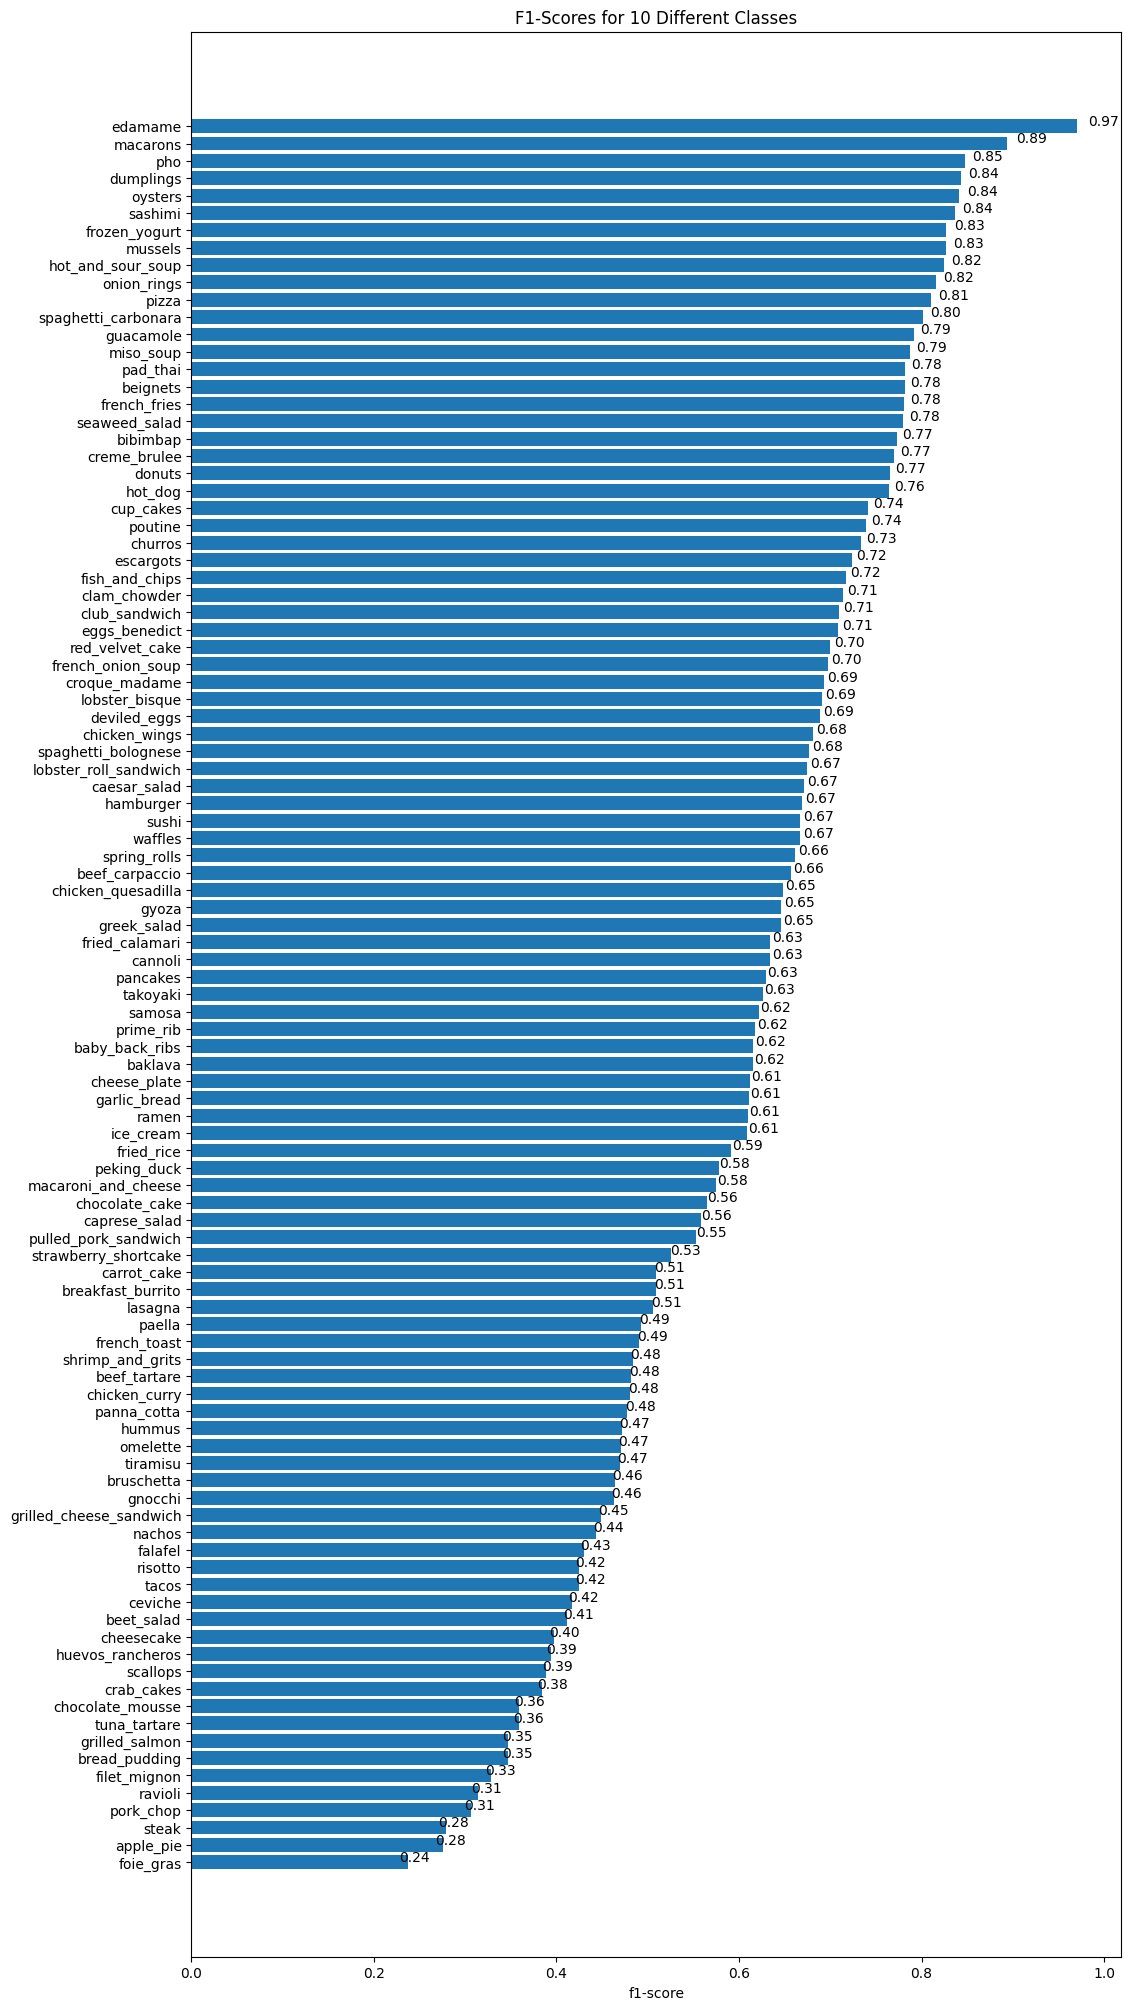

In [35]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [36]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 24ms/step


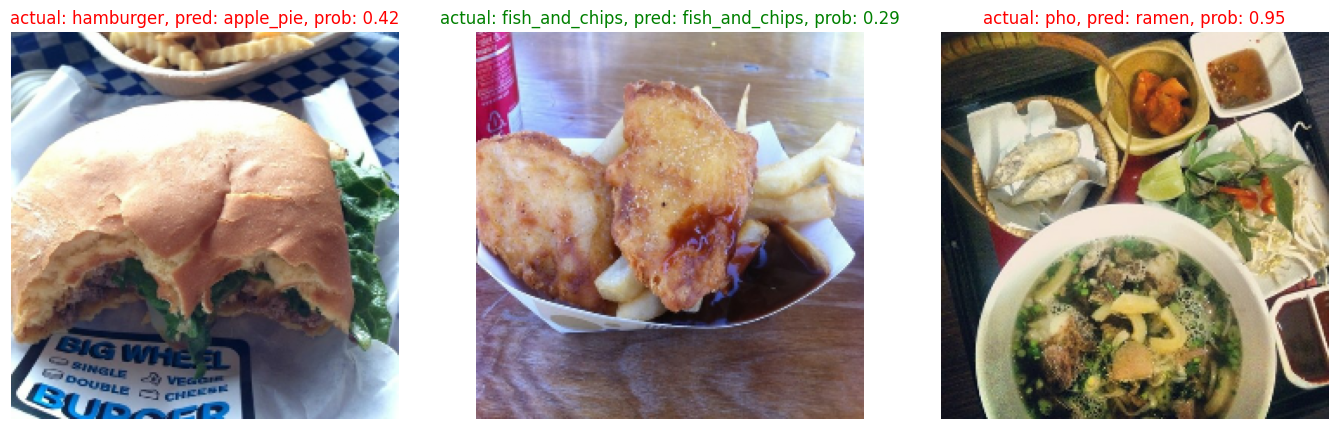

In [37]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [38]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [39]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      28   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname      y_pred_classname  
0   0.296981        apple_pie         croque_madame  
1   0.947003        apple_pie             apple_pie  
2   0.519086        apple_pie             apple_pie  
3   0.386165        apple_pie  pulled_pork_sandwich  
4   0.351450        apple_pie         bread_pudding

In [40]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      28   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.296981        apple_pie         croque_madame         False  
1   0.947003        apple_pie             apple_pie          True  
2   0.519086        apple_pie             apple_pie          True  
3   0.386165        apple_pie  pulled_pork_sandwich         False  
4   0.351450        apple_pie         bread_pudding         False

In [41]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
9326   b'101_food_classes_10_percent/test/filet_migno...      37      79   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
16271  b'101_food_classes_10_percent/test/mussels/140...      65      69   
10013  b'101_food_classes_10_percent/test/french_frie...      40      43   
23300  b'101_food_classes_10_percent/test/steak/17945...      93       1   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
11024  b'101_food_classes_10_percent/test/fried_rice/...      44      70   
722    b'101_food_classes_10_percent/test/baklava/640...       2      85   
14691  b'101_food_classes_10_percent/test/ice_cream/3...      58      79   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
20615  b'101_food_classes_10_percent/test/ravioli/277...      82      84   
7295   b'101_food_classes_10_percent/test/cup_cakes/1...      29      31   
8076   b'101_food_classes_10_percent/test/dumplings/2...      32      57   
14300  b'101_food_classes_10_percent/test/hummus/1800...      57      19   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf y_true_classname    y_pred_classname  pred_correct  
11642   0.998748     garlic_bread          bruschetta         False  
8794    0.996834        escargots   french_onion_soup         False  
9326    0.996272     filet_mignon           prime_rib         False  
191     0.996250        apple_pie              donuts         False  
15142   0.996061   lobster_bisque           miso_soup         False  
17855   0.995835           paella             mussels         False  
18001   0.994725         pancakes            omelette         False  
16271   0.994622          mussels             oysters         False  
10013   0.994238     french_fries      fried_calamari         False  
23300   0.993676            steak      baby_back_ribs         False  
21810   0.993644         scallops           cup_cakes         False  
11024   0.993254       fried_rice            pad_thai         False  
722     0.992681          baklava              samosa         False  
14691   0.992245        ice_cream           prime_rib         False  
23797   0.992154            sushi             sashimi         False  
20615   0.991984          ravioli             risotto         False  
7295    0.991724        cup_cakes              donuts         False  
8076    0.991306        dumplings              hummus         False  
14300   0.991054           hummus  chicken_quesadilla         False  
10847   0.990648   fried_calamari         onion_rings         False

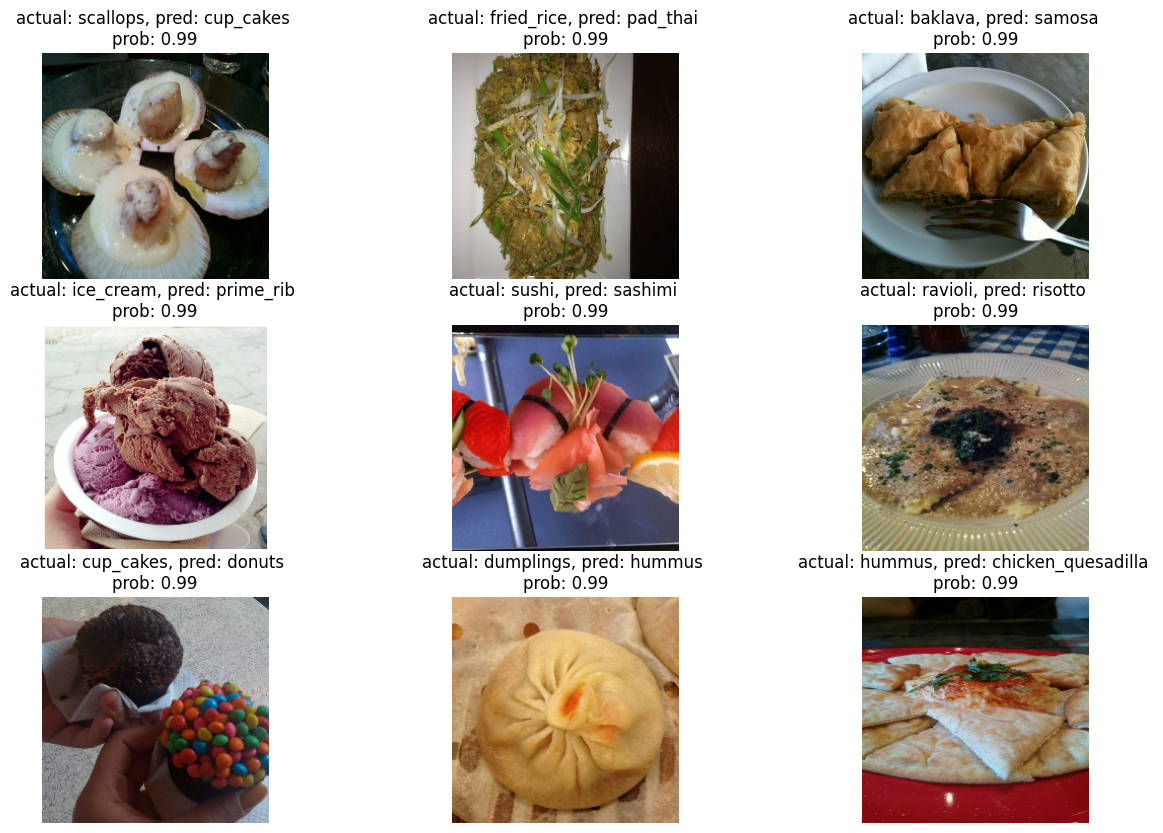

In [43]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [42]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-01-15 20:12:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2024-01-15 20:12:25 (83.9 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [45]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg']

1/1 [==============================] - 0s 31ms/step


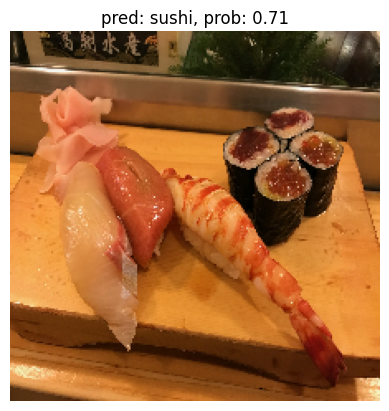

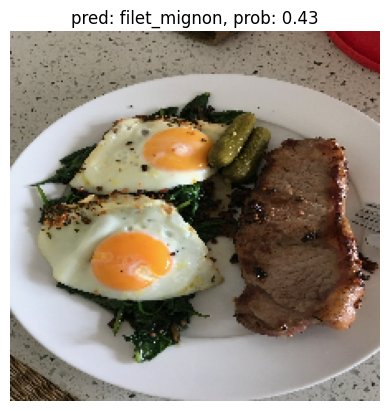

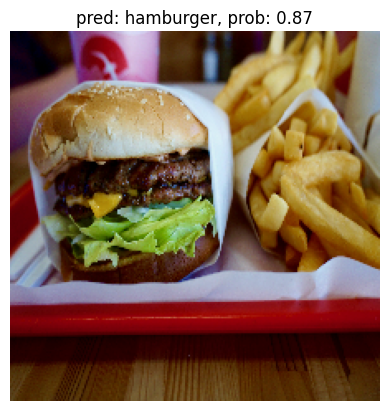

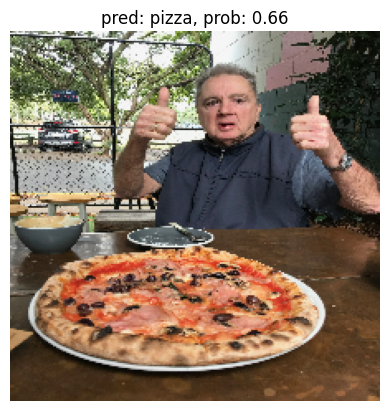

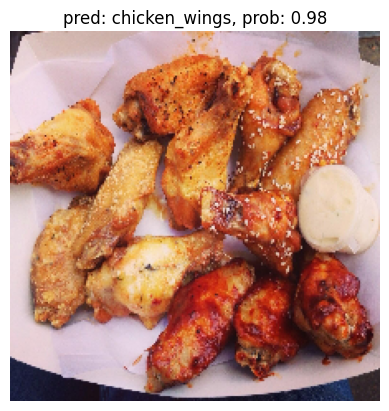

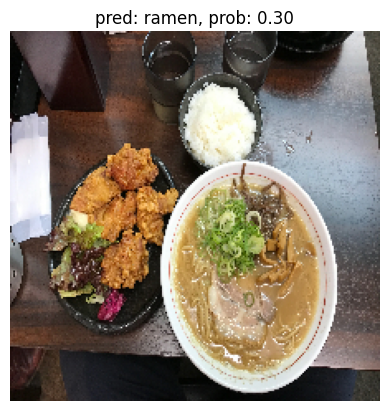

In [46]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)